# Prophet training
This is an auto-generated notebook. To reproduce these results, attach this notebook to the **henry data's Cluster** cluster and rerun it.
- Compare trials in the [MLflow experiment](#mlflow/experiments/2402465695741674/s?orderByKey=metrics.%60val_mse%60&orderByAsc=true)
- Navigate to the parent notebook [here](#notebook/2402465695741675) (If you launched the AutoML experiment using the Experiments UI, this link isn't very useful.)
- Clone this notebook into your project folder by selecting **File > Clone** in the notebook toolbar.

Runtime Version: _11.1.x-cpu-ml-scala2.12_

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "siniestros"
time_col = "date"
unit = "day"

horizon = 360

## Load Data

In [0]:
from mlflow.tracking import MlflowClient
import os
import uuid
import shutil
import pandas as pd
import pyspark.pandas as ps

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join("/dbfs/tmp/", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)

# Download the artifact and read it into a pandas DataFrame
input_client = MlflowClient()
input_data_path = input_client.download_artifacts("b303c3756fb1448e9137f7356680db23", "data", input_temp_dir)

input_file_path = os.path.join(input_data_path, "training_data")
input_file_path = "file://" + input_file_path
df_loaded = ps.from_pandas(pd.read_parquet(input_file_path))

# Preview data
df_loaded.head(5)

,date,siniestros
0,2021-07-08,305
1,2021-07-20,286
2,2020-07-13,290
3,2021-08-27,349
4,2020-05-13,212


## Train Prophet model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/2402465695741674/s?orderByKey=metrics.%60val_mse%60&orderByAsc=true)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment

### Aggregate data by `time_col`
Group the data by `time_col`, and take avearge if there are multiple `target_col` values in the same group.

In [0]:
group_cols = [time_col]
df_aggregated = df_loaded \
  .groupby(group_cols) \
  .agg(y=(target_col, "avg")) \
  .reset_index() \
  .rename(columns={ time_col : "ds" })

df_aggregated.head()

,ds,y
0,2021-07-08,305.0
1,2021-07-20,286.0
2,2020-07-13,290.0
3,2021-08-27,349.0
4,2020-05-13,212.0


In [0]:
import logging

# disable informational messages from prophet
logging.getLogger("py4j").setLevel(logging.WARNING)

In [0]:
result_columns = ["model_json", "mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]

def prophet_training(history_pd):
  from hyperopt import hp
  from databricks.automl_runtime.forecast.prophet.forecast import ProphetHyperoptEstimator

  seasonality_mode = ["additive", "multiplicative"]
  search_space =  {
    "changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", -6.9, -0.69),
    "seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", -6.9, 2.3),
    "holidays_prior_scale": hp.loguniform("holidays_prior_scale", -6.9, 2.3),
    "seasonality_mode": hp.choice("seasonality_mode", seasonality_mode)
  }
  country_holidays = None
  run_parallel = True
 
  hyperopt_estim = ProphetHyperoptEstimator(horizon=horizon, frequency_unit=unit, metric="mse",interval_width=0.8,
                   country_holidays=country_holidays, search_space=search_space, num_folds=20, max_eval=10, trial_timeout=3569,
                   random_state=216265592, is_parallel=run_parallel)

  spark.conf.set("spark.databricks.mlflow.trackHyperopt.enabled", "false")

  results_pd = hyperopt_estim.fit(history_pd)

  spark.conf.set("spark.databricks.mlflow.trackHyperopt.enabled", "true")
 
  return results_pd[result_columns]

In [0]:
import mlflow
from databricks.automl_runtime.forecast.prophet.model import mlflow_prophet_log_model, ProphetModel

with mlflow.start_run(experiment_id="2402465695741674", run_name="PROPHET") as mlflow_run:
  mlflow.set_tag("estimator_name", "Prophet")
  mlflow.log_param("interval_width", 0.8)

  forecast_results = prophet_training(df_aggregated.to_pandas())
    
  # Log the metrics to mlflow
  avg_metrics = forecast_results[["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]].mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Create mlflow prophet model
  model_json = forecast_results["model_json"].to_list()[0]
  prophet_model = ProphetModel(model_json, horizon, unit, time_col)
  mlflow_prophet_log_model(prophet_model)

Because the requested parallelism was None or a non-positive value, parallelism will be set to (8), which is Spark's default parallelism (8), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt + MLflow integration is feature-flagged off.  To enable automatic tracking in MLflow, set via: `spark.conf.set('spark.databricks.mlflow.trackHyperopt.enabled', 'true')` where `spark` is your SparkSession.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
100%|██████████| 10/10 [00:28<00:00,  2.81s/trial, best loss: 1036.6248042352775]
Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=

In [0]:
forecast_results.head(5)

,model_json,mse,rmse,mae,mape,mdape,smape,coverage
0,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp...",1036.624804,31.111275,25.422478,0.091148,0.076335,0.088404,0.935455


## Analyze the predicted results

In [0]:
# Load the model
run_id = mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

2022/09/08 21:32:42 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - prophet (current: 1.0.1, required: prophet==1.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [0]:
# Predict future with the default horizon
forecast_pd = loaded_model._model_impl.python_model.predict_timeseries()

In [0]:
# Plotly plots is turned off by default because it takes up a lot of storage.
# Set this flag to True and re-run the notebook to see the interactive plots with plotly
use_plotly = False

In [0]:
# Get prophet model
model = loaded_model._model_impl.python_model.model()
predict_pd = forecast_pd

### Plot the forecast with change points and trend

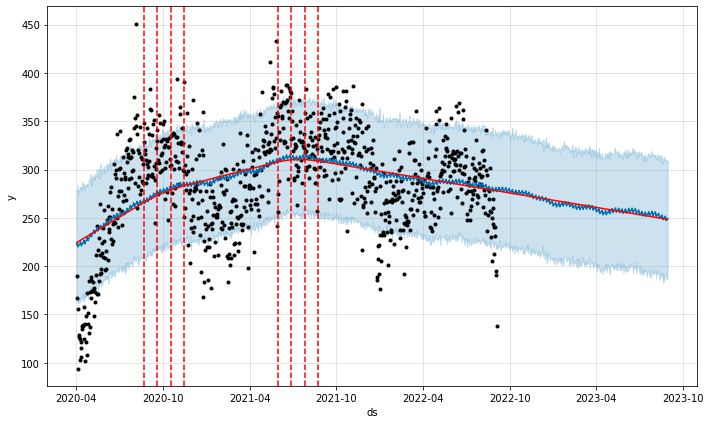

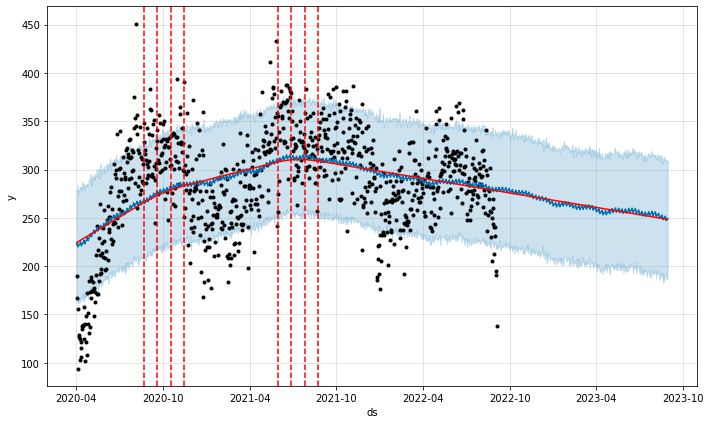

In [0]:
from prophet.plot import add_changepoints_to_plot, plot_plotly

if use_plotly:
    fig = plot_plotly(model, predict_pd, changepoints=True, trend=True, figsize=(1200, 600))
else:
    fig = model.plot(predict_pd)
    a = add_changepoints_to_plot(fig.gca(), model, predict_pd)
fig

### Plot the forecast components

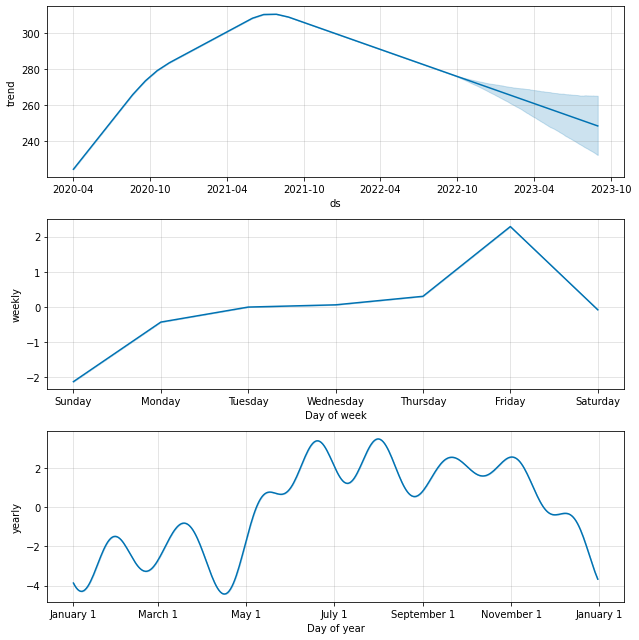

In [0]:
from prophet.plot import plot_components_plotly
if use_plotly:
    fig = plot_components_plotly(model, predict_pd, figsize=(900, 400))
    fig.show()
else:
    fig = model.plot_components(predict_pd)

## Show the predicted results

In [0]:
predict_cols = ["ds", "yhat"]
forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].tail(horizon))

ds,yhat
2022-09-05T00:00:00.000+0000,278.7887663061984
2022-09-06T00:00:00.000+0000,279.2556705786815
2022-09-07T00:00:00.000+0000,279.35993902846576
2022-09-08T00:00:00.000+0000,279.64224089279134
2022-09-09T00:00:00.000+0000,281.66305463442046
2022-09-10T00:00:00.000+0000,279.3314357466829
2022-09-11T00:00:00.000+0000,277.3141879070257
2022-09-12T00:00:00.000+0000,279.02756055359015
2022-09-13T00:00:00.000+0000,279.46654367680685
2022-09-14T00:00:00.000+0000,279.53231695531207
